# 混淆矩阵

通过测试集所有图像预测结果，生成多类别混淆矩阵，评估模型准确度。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置Matplotlib中文字体

In [1]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [5]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-11 15:36:28--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  16.6MB/s    in 0.6s    

2022-08-11 15:36:29 (16.6 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



## 导入工具包

In [43]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import math
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 载入类别名称和ID

In [8]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['丝瓜', '人参果', '佛手瓜', '冬瓜', '南瓜', '哈密瓜', '木瓜', '甜瓜-伊丽莎白', '甜瓜-白', '甜瓜-绿', '甜瓜-金', '白兰瓜', '羊角蜜', '苦瓜', '西瓜', '西葫芦', '黄瓜']


## 载入测试集预测结果表格

In [9]:
df = pd.read_csv('测试集预测结果.csv')

In [11]:
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,甜瓜-伊丽莎白-预测置信度,甜瓜-白-预测置信度,甜瓜-绿-预测置信度,甜瓜-金-预测置信度,白兰瓜-预测置信度,羊角蜜-预测置信度,苦瓜-预测置信度,西瓜-预测置信度,西葫芦-预测置信度,黄瓜-预测置信度
0,melon17_split/val/丝瓜/109.jpg,0,丝瓜,0.0,丝瓜,2.0,佛手瓜,12.0,羊角蜜,1.0,...,0.002193,0.014018,0.014891,0.003501,0.006260,0.092346,0.001454,0.003925,0.006661,0.001151
1,melon17_split/val/丝瓜/111.jpg,0,丝瓜,0.0,丝瓜,13.0,苦瓜,15.0,西葫芦,1.0,...,0.000567,0.000372,0.000705,0.002064,0.000421,0.072553,0.195918,0.000510,0.144077,0.048166
2,melon17_split/val/丝瓜/113.jpg,0,丝瓜,0.0,丝瓜,5.0,哈密瓜,11.0,白兰瓜,1.0,...,0.022293,0.033744,0.002499,0.009714,0.108798,0.044752,0.009132,0.011167,0.098024,0.035007
3,melon17_split/val/丝瓜/115.jpg,0,丝瓜,3.0,冬瓜,0.0,丝瓜,15.0,西葫芦,1.0,...,0.000888,0.003155,0.003725,0.001007,0.006776,0.002390,0.007951,0.001781,0.100773,0.006788
4,melon17_split/val/丝瓜/120.jpg,0,丝瓜,0.0,丝瓜,15.0,西葫芦,16.0,黄瓜,1.0,...,0.001660,0.000126,0.000372,0.003168,0.000812,0.015668,0.047193,0.000766,0.142601,0.080202


## 生成混淆矩阵

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])

In [14]:
confusion_matrix_model

array([[30,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,
         2],
       [ 0, 33,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 1,  1, 25,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1],
       [ 3,  0,  0, 20,  0,  1,  0,  0,  0,  1,  0,  1,  0,  1,  1,  2,
         0],
       [ 0,  0,  0,  0, 31,  1,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0],
       [ 0,  0,  0,  0,  0, 35,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  1,  2,  1, 32,  0,  0,  1,  1,  0,  0,  0,  0,  0,
         0],
       [ 0,  1,  0,  1,  0,  1,  0,  8,  2,  0,  1,  3,  0,  0,  1,  0,
         0],
       [ 0,  0,  0,  0,  0,  1,  0,  1, 11,  1,  0,  3,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  4,  0,  0,  0,  0,  1,  1,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  7,  1,  0,  0,  0,  1,
         0],
       [ 0,  1,  0,  1,  0,  4,  0,  0,  7,  0,  0, 12,  0,  0,  

## 可视化混淆矩阵

In [15]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测', fontsize=25, c='r')
    plt.ylabel('真实', fontsize=25, c='r')
    plt.tick_params(labelsize=18) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=16)

    plt.tight_layout()

    # plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [16]:
# 查看所有配色方案
# dir(plt.cm)

In [17]:
# 子豪兄精选配色方案
# Blues
# BuGn
# Reds
# Greens
# Greys
# binary
# Oranges
# Purples
# BuPu
# GnBu
# OrRd
# RdPu

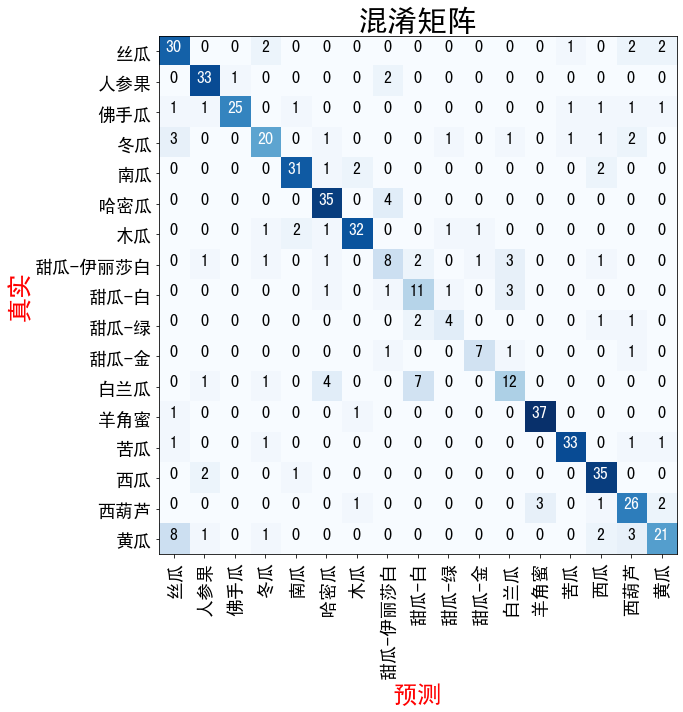

In [18]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 筛选出测试集中，真实为A类，但被误判为B类的图像

In [62]:
class_A = '丝瓜'
class_B = '西葫芦'

In [63]:
wrong_df = df[(df['标注类别名称']==class_A)&(df['top-1-预测名称']==class_B)]

In [64]:
wrong_df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,甜瓜-伊丽莎白-预测置信度,甜瓜-白-预测置信度,甜瓜-绿-预测置信度,甜瓜-金-预测置信度,白兰瓜-预测置信度,羊角蜜-预测置信度,苦瓜-预测置信度,西瓜-预测置信度,西葫芦-预测置信度,黄瓜-预测置信度
10,melon17_split/val/丝瓜/163.jpg,0,丝瓜,15.0,西葫芦,12.0,羊角蜜,0.0,丝瓜,1.0,...,0.000370,0.000330,0.003445,0.008878,0.000655,0.116867,0.031457,0.000347,0.656038,0.023713
33,melon17_split/val/丝瓜/93.jpg,0,丝瓜,15.0,西葫芦,0.0,丝瓜,13.0,苦瓜,1.0,...,0.002123,0.011163,0.008510,0.002560,0.045944,0.023775,0.096168,0.013328,0.309475,0.075122


## 可视化被误判的图像

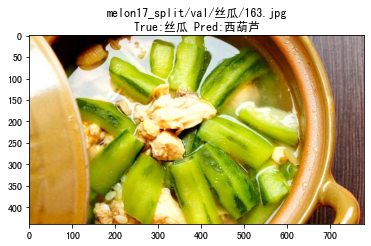

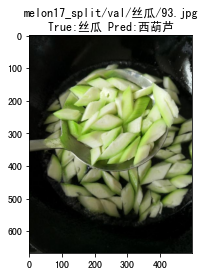

In [65]:
for idx, row in wrong_df.iterrows():
    img_path = row['图像路径']
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    title_str = img_path + '\nTrue:' + row['标注类别名称'] + ' Pred:' + row['top-1-预测名称']
    plt.title(title_str)
    plt.show()